<a href="https://colab.research.google.com/github/BryanSouza91/COVID-19/blob/master/COVID19_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf
tf.__version__

'2.2.0'

In [3]:
tf.random.set_seed(29)

In [4]:
confirmed_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
recovered_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
deaths_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

In [5]:
conf_df = pd.read_csv(confirmed_url)
recv_df = pd.read_csv(recovered_url)
death_df = pd.read_csv(deaths_url)

In [6]:
print(conf_df.loc[:,'1/22/20':].sum().tail())
print(recv_df.loc[:,'1/22/20':].sum().tail())
print(death_df.loc[:,'1/22/20':].sum().tail())

7/2/20    10871926
7/3/20    11076086
7/4/20    11269114
7/5/20    11452196
7/6/20    11620096
dtype: int64
7/2/20    5754006
7/3/20    5863847
7/4/20    6059565
7/5/20    6179006
7/6/20    6302626
dtype: int64
7/2/20    521361
7/3/20    526419
7/4/20    530767
7/5/20    534280
7/6/20    538058
dtype: int64


In [7]:
print("New cases as of {}: {}".format(conf_df.columns[-1],(conf_df.loc[::].sum()[-1] - conf_df.loc[::].sum()[-2])))
print("New case rate: {0:.3%}".format((conf_df.loc[::].sum()[-1] - conf_df.loc[::].sum()[-2])/ conf_df.loc[::].sum()[-2]))
print("Death rate: {0:.3%}".format(death_df.loc[::].sum()[-1]/conf_df.loc[::].sum()[-1]))

New cases as of 7/6/20: 167900
New case rate: 1.466%
Death rate: 4.630%


In [8]:
# create a differenced series function

def difference(dataset, interval=1):
    return pd.Series([dataset[i] - dataset[i - interval] for i in range(interval, len(dataset))])

In [9]:
def standardize(x, mean, std):
  return (x - mean) / std

def inv_standardize(x, mean, std):
  return (x * std) + mean

In [10]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [27]:
# define input sequence
data = conf_df.loc[:,'1/22/20':].sum().values
# data = difference(data)

raw_seq = np.log10(data)

# get mean and std
TRAIN_SPLIT = int(len(raw_seq)*.8)
print(TRAIN_SPLIT)
MEAN = raw_seq[:TRAIN_SPLIT].mean()
STD = raw_seq[:TRAIN_SPLIT].std()
stand_seq = standardize(raw_seq, MEAN, STD)

# choose a number of time steps

n_steps_in, n_steps_out = 9, 3

# split into samples

X, y = split_sequence(stand_seq, n_steps_in, n_steps_out)

for i in range(len(X)):
  print(X[i], y[i])

133
[-2.84732032 -2.77630291 -2.61888366 -2.43661032 -2.26786876 -2.12789892
 -1.84889348 -1.80553171 -1.68039546] [-1.59949287 -1.5160706  -1.37219349]
[-2.77630291 -2.61888366 -2.43661032 -2.26786876 -2.12789892 -1.84889348
 -1.80553171 -1.68039546 -1.59949287] [-1.5160706  -1.37219349 -1.29887333]
[-2.61888366 -2.43661032 -2.26786876 -2.12789892 -1.84889348 -1.80553171
 -1.68039546 -1.59949287 -1.5160706 ] [-1.37219349 -1.29887333 -1.21938031]
[-2.43661032 -2.26786876 -2.12789892 -1.84889348 -1.80553171 -1.68039546
 -1.59949287 -1.5160706  -1.37219349] [-1.29887333 -1.21938031 -1.15640946]
[-2.26786876 -2.12789892 -1.84889348 -1.80553171 -1.68039546 -1.59949287
 -1.5160706  -1.37219349 -1.29887333] [-1.21938031 -1.15640946 -1.10959037]
[-2.12789892 -1.84889348 -1.80553171 -1.68039546 -1.59949287 -1.5160706
 -1.37219349 -1.29887333 -1.21938031] [-1.15640946 -1.10959037 -1.06181447]
[-1.84889348 -1.80553171 -1.68039546 -1.59949287 -1.5160706  -1.37219349
 -1.29887333 -1.21938031 -1.15

In [28]:
# reshape from [samples, timesteps] into [samples, timesteps, features]

n_features = 1

X = X.reshape((X.shape[0], X.shape[1], n_features))
X.shape

(156, 9, 1)

In [29]:
# define model

def get_compiled_model(n_steps_in, n_steps_out, n_features):
  model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(96, 2, activation='elu', input_shape=(n_steps_in, n_features)),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(32, 2, activation='elu'),
    tf.keras.layers.MaxPooling1D(1),
    tf.keras.layers.Conv1D(32, 1, activation='elu'),
    tf.keras.layers.MaxPooling1D(1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='elu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(1024),
    tf.keras.layers.Dense(n_steps_out)
  ])

  model.compile(optimizer='adam', loss='mae')

  return model

In [30]:
model = get_compiled_model(n_steps_in,n_steps_out,n_features)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 8, 96)             288       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 4, 96)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 3, 32)             6176      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 3, 32)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 3, 32)             1056      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 3, 32)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 96)               

In [31]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=.9, patience=6, min_lr=1e-7, verbose=1)

In [32]:
# fit model
hist = model.fit(X, y, validation_split=.2, epochs=200, verbose=1, shuffle=True, callbacks=[early_stop])

Epoch 1/200
4/4 [==============================] - 0s 29ms/step - loss: 0.5137 - val_loss: 0.6977
Epoch 2/200
4/4 [==============================] - 0s 13ms/step - loss: 0.2787 - val_loss: 0.4396
Epoch 3/200
4/4 [==============================] - 0s 11ms/step - loss: 0.1474 - val_loss: 0.3181
Epoch 4/200
4/4 [==============================] - 0s 12ms/step - loss: 0.1434 - val_loss: 0.1787
Epoch 5/200
4/4 [==============================] - 0s 12ms/step - loss: 0.1257 - val_loss: 0.2262
Epoch 6/200
4/4 [==============================] - 0s 12ms/step - loss: 0.1340 - val_loss: 0.1073
Epoch 7/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0878 - val_loss: 0.1306
Epoch 8/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0802 - val_loss: 0.0403
Epoch 9/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0702 - val_loss: 0.0431
Epoch 10/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0559 - val_loss: 0.0343
Epoch 11/200
4/4 [=

In [35]:
# demonstrate prediction
x_input = np.log10(conf_df.loc[:,'1/22/20':].sum()[-(n_steps_in+1):-1].to_numpy())
x_inMEAN = x_input.mean()
x_inSTD = x_input.std()
x_input = standardize(x_input, x_inMEAN, x_inSTD)
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
yhat = inv_standardize(yhat, x_inMEAN, x_inSTD)
print("Prediction: {0:.0f} True: {1:.0f}".format((10 ** yhat[0][-1]), (10 ** raw_seq[-1])))
PE = (((10 ** yhat[0][-1] - 10 ** raw_seq[-1])/10 ** raw_seq[-1]))
print("Percent Error: {0:.3%}".format(PE))

Prediction: 11500535 True: 11620096
Percent Error: -1.029%


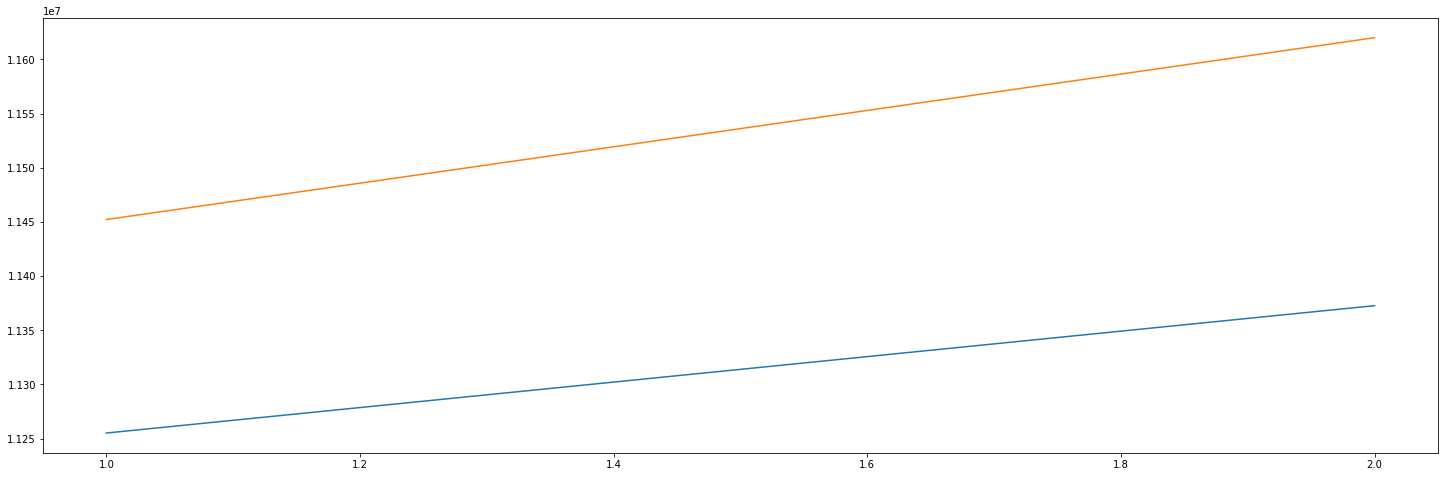

In [36]:
plt.figure(figsize=(25,8))
sns.lineplot([n for n in range(1,3)],[10**n for n in yhat[0][:2]]);
sns.lineplot([n for n in range(1,3)],conf_df.loc[:,'1/22/20':].sum()[-3:].to_numpy()[1:]);

In [37]:
# prediction for tomorrow
x_input = np.log10(conf_df.loc[:,'1/22/20':].sum()[-n_steps_in:].to_numpy())
x_inMEAN = x_input.mean()
x_inSTD = x_input.std()
x_input = standardize(x_input, x_inMEAN, x_inSTD)
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
yhat = inv_standardize(yhat, x_inMEAN, x_inSTD)
print("%d" % (10 ** yhat[0][-1]))

11668465


In [38]:
for pred in yhat[0]:
  print("%d" % (10 ** pred))

11431885
11542787
11668465


In [39]:
hist = pd.DataFrame(hist.history)

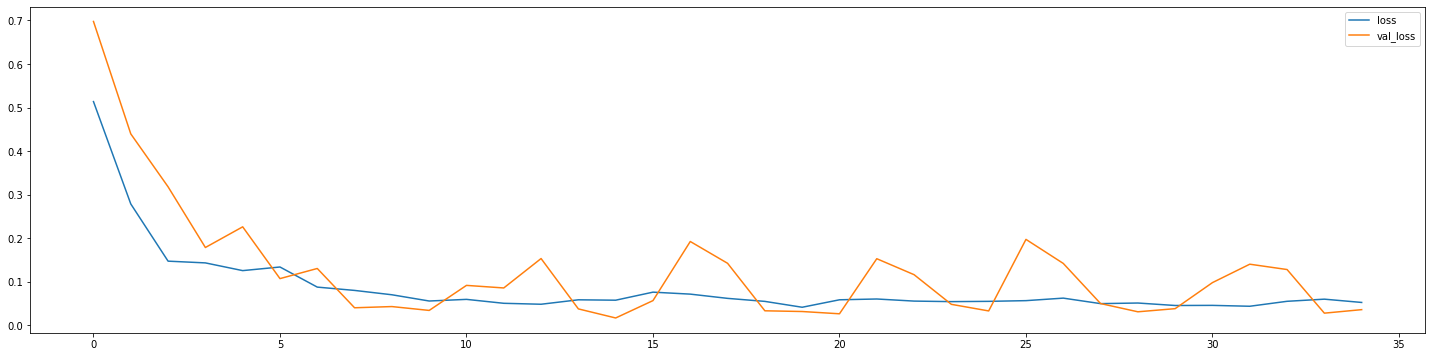

In [40]:
hist.plot(figsize=(25,6));

In [41]:
[10**n for n in yhat[0]],conf_df.loc[:,'1/22/20':].sum()[-3:].to_numpy()

([11431885.514158778, 11542787.371759297, 11668465.340561993],
 array([11269114, 11452196, 11620096]))